## General


Cost distance schematic

Cost Map 2d/3d

In [56]:
import numpy as np
x_dim = 850
y_dim = x_dim
center_x, center_y = x_dim / 2, y_dim / 2
inner_radius, outer_radius = 250, 400
ref_x, ref_y = center_x, center_y + (inner_radius + outer_radius) / 2
opponent_x, opponent_y = ref_x, ref_y

def proximity_cost(x1, y1, threshold=50, weight=1.0):
    dx = x1 - opponent_x
    dy = y1 - opponent_y
    dist = np.sqrt(dx ** 2 + dy ** 2)
    cost = np.zeros_like(dist)
    within = dist < threshold

    # cost[within] = weight * np.exp(-(2 * 1 / threshold * dist[within]))
    cost[within] = weight * (1 - dist[within]/threshold)

    return cost

In [ ]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math

# Constants - adjust these to modify the visualization
resolution = 200
x_dim = 850
y_dim = x_dim

# Cost function weights
bounds_weight = 0.005
progress_weight = 0.08
proximity_weight = 1.0
bounds_spread = 205
proximity_threshold = 50

# Track geometry
center_x, center_y = x_dim / 2, y_dim / 2
inner_radius, outer_radius = 250, 400

# Vehicle positions
ref_x, ref_y = center_x, center_y + (inner_radius + outer_radius) / 2
opponent_x, opponent_y = ref_x, ref_y
ego_x, ego_y = center_x, center_y - (inner_radius + outer_radius) / 2

# Create coordinate grid
x = np.linspace(0, x_dim, resolution)
y = np.linspace(0, y_dim, resolution)
X, Y = np.meshgrid(x, y)

def out_of_bounds_cost(x, y, weight=1, spread=100):
    dx = x - center_x
    dy = y - center_y
    distance_to_center = np.hypot(dx, dy)
    
    # Initialize cost array with zeros
    cost = np.zeros_like(distance_to_center)
    
    # Inside inner radius
    inside_mask = distance_to_center < inner_radius
    cost = np.where(inside_mask, weight * (inner_radius - distance_to_center), cost)
    
    # Outside outer radius
    outside_mask = distance_to_center > outer_radius
    cost = np.where(outside_mask, weight * (distance_to_center - outer_radius), cost)
    
    # Between inner and outer radius, cost remains 0
    return cost

def relative_progress_cost(x1, y1, weight=1):
    def angle(x, y):
        return (np.arctan2(y - center_y, x - center_x) + 2 * np.pi) % (2 * np.pi)
    angle1 = angle(x1, y1)
    angle2 = angle(ref_x, ref_y)
    delta = angle1 - angle2
    delta = np.where(delta < -np.pi, delta + 2 * np.pi, delta)
    delta = np.where(delta > np.pi, delta - 2 * np.pi, delta)
    return weight * delta



def generate_circle(cx, cy, radius, resolution=200):
    theta = np.linspace(0, 2 * np.pi, resolution)
    x_circle = cx + radius * np.cos(theta)
    y_circle = cy + radius * np.sin(theta)
    return x_circle, y_circle

# Calculate combined cost surface
Z1 = out_of_bounds_cost(X, Y, bounds_weight, spread=bounds_spread)
Z2 = relative_progress_cost(X, Y, progress_weight)
Z3 = proximity_cost(X, Y, threshold=proximity_threshold, weight=proximity_weight)
Z = Z1 + Z2 + Z3

# Get z-values for vehicle positions
ix = np.abs(x - opponent_x).argmin()
iy = np.abs(y - opponent_y).argmin()
opponent_z = Z[iy, ix]

ix = np.abs(x - ego_x).argmin()
iy = np.abs(y - ego_y).argmin()
ego_z = Z[iy, ix-10]

# Generate track boundary circles
inner_x, inner_y = generate_circle(center_x, center_y, inner_radius)
outer_x, outer_y = generate_circle(center_x, center_y, outer_radius)

# Create subplots: 1 row, 2 columns
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('2D Cost Surface', '3D Cost Surface'),
    specs=[[{"type": "xy"}, {"type": "scene"}]],
    horizontal_spacing=0.1
)
fig.update_annotations(font_size=24)

# Add 2D heatmap plot (left subplot)
fig.add_trace(
    go.Heatmap(
        z=Z, x=x, y=y,
        colorscale='Viridis',
        showlegend=False,
        colorbar=dict(
                x=0.45, 
                len=0.8, 
                title=dict(
                    text="Cost Value",
                    side="right",
                    font=dict(size=18)
                ))),
    row=1, col=1
)

# Add track boundaries to 2D plot
fig.add_trace(
    go.Scatter(
        x=inner_x, y=inner_y,
        mode='lines',
        line=dict(color='black', width=3),
        showlegend=False
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=outer_x, y=outer_y,
        mode='lines',
        line=dict(color='black', width=3),
        showlegend=False
    ),
    row=1, col=1
)

# Add vehicle markers to 2D plot
fig.add_trace(
    go.Scatter(
        x=[opponent_x], y=[opponent_y],
        mode='markers+text',
        marker=dict(size=10, color='blue'),
        text=["<b>Opponent</b>"],
        textposition='top center',
        textfont=dict(size=14, color='black'),
        showlegend=False
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=[ego_x], y=[ego_y],
        mode='markers+text',
        marker=dict(size=10, color='green'),
        text=["<b>Ego</b>"],
        textposition='middle left',
        textfont=dict(size=14, color='black'),
        showlegend=False
    ),
    row=1, col=1
)

# Add 3D surface plot (right subplot)
fig.add_trace(
    go.Surface(
        z=Z, x=X, y=Y,
        colorscale='Viridis',
        opacity=0.95,
        showlegend=False,
        showscale=False
    ),
    row=1, col=2
)

# Add track boundaries to 3D plot
inner_z = np.full_like(inner_x, Z.min())
outer_z = np.full_like(outer_x, Z.min())
fig.add_trace(
    go.Scatter3d(
        x=inner_x, y=inner_y, z=inner_z,
        mode='lines',
        line=dict(color='black', width=4),
        showlegend=False
    ),
    row=1, col=2
)
fig.add_trace(
    go.Scatter3d(
        x=outer_x, y=outer_y, z=outer_z,
        mode='lines',
        line=dict(color='black', width=4),
        showlegend=False
    ),
    row=1, col=2
)

# Add vehicle markers to 3D plot
fig.add_trace(
    go.Scatter3d(
        x=[opponent_x], y=[opponent_y], z=[opponent_z],
        mode='markers+text',
        marker=dict(size=6, color='blue'),
        text=["<b>Opponent</b>"],
        textposition='top center',
        textfont=dict(size=14, color='black'),
        showlegend=False
    ),
    row=1, col=2
)
fig.add_trace(
    go.Scatter3d(
        x=[ego_x], y=[ego_y], z=[ego_z],
        mode='markers+text',
        marker=dict(size=6, color='green'),
        text=["<b>Ego</b>"],
        textposition='top center',
        textfont=dict(size=14, color='black'),
        showlegend=False
    ),
    row=1, col=2
)

# Update layout
fig.update_layout(
    width=1400,
    height=700,
    showlegend=False,
)

# Update 2D subplot axes
fig.update_xaxes(title_text="X", row=1, col=1)
fig.update_yaxes(title_text="Y", row=1, col=1)

# Update 3D scene
fig.update_scenes(
    xaxis_title="X",
    yaxis_title="Y",
    zaxis_title="Cost",
    aspectmode='manual',
    aspectratio=dict(x=1, y=1, z=0.3),
    row=1, col=2
)

# Show the plot
fig.show()

In [60]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math

# Constants - adjust these to modify the visualization
resolution = 200
x_dim = 850
y_dim = x_dim

# Cost function weights
bounds_weight = 0.6
progress_weight = 0.2
proximity_weight = 1.0
bounds_spread = 180
proximity_threshold = 50

# Track geometry
center_x, center_y = x_dim / 2, y_dim / 2
inner_radius, outer_radius = 250, 400

# Vehicle positions
ref_x, ref_y = center_x, center_y + (inner_radius + outer_radius) / 2
opponent_x, opponent_y = ref_x, ref_y
ego_x, ego_y = center_x, center_y - (inner_radius + outer_radius) / 2

# Create coordinate grid
x = np.linspace(0, x_dim, resolution)
y = np.linspace(0, y_dim, resolution)
X, Y = np.meshgrid(x, y)

def out_of_bounds_cost(x, y, weight=1, spread=100):
    dx = x - center_x
    dy = y - center_y
    distance_to_center = np.hypot(dx, dy)
    radius = (outer_radius + inner_radius) / 2
    distance_to_perimeter = abs(distance_to_center - radius)
    cost = weight * (1 - np.exp(-(2 / spread * distance_to_perimeter) ** 2))
    return cost

def relative_progress_cost(x1, y1, weight=1):
    def angle(x, y):
        return (np.arctan2(y - center_y, x - center_x) + 2 * np.pi) % (2 * np.pi)
    angle1 = angle(x1, y1)
    angle2 = angle(ref_x, ref_y)
    delta = angle1 - angle2
    delta = np.where(delta < -np.pi, delta + 2 * np.pi, delta)
    delta = np.where(delta > np.pi, delta - 2 * np.pi, delta)
    return weight * delta

def proximity_cost(x1, y1, threshold=50, weight=1.0):
    dx = x1 - opponent_x
    dy = y1 - opponent_y
    dist = np.sqrt(dx ** 2 + dy ** 2)
    cost = np.zeros_like(dist)
    within = dist < threshold
    cost[within] = weight * np.exp(-(2 * 1 / threshold * dist[within]))
    return cost

def generate_circle(cx, cy, radius, resolution=200):
    theta = np.linspace(0, 2 * np.pi, resolution)
    x_circle = cx + radius * np.cos(theta)
    y_circle = cy + radius * np.sin(theta)
    return x_circle, y_circle

# Calculate combined cost surface
Z1 = out_of_bounds_cost(X, Y, bounds_weight, spread=bounds_spread)
Z2 = relative_progress_cost(X, Y, progress_weight)
Z3 = proximity_cost(X, Y, threshold=proximity_threshold, weight=proximity_weight)
Z = Z1 + Z2 + Z3

# Get z-values for vehicle positions
ix = np.abs(x - opponent_x).argmin()
iy = np.abs(y - opponent_y).argmin()
opponent_z = Z[iy, ix]

ix = np.abs(x - ego_x).argmin()
iy = np.abs(y - ego_y).argmin()
ego_z = Z[iy, ix-10]

# Generate track boundary circles
inner_x, inner_y = generate_circle(center_x, center_y, inner_radius)
outer_x, outer_y = generate_circle(center_x, center_y, outer_radius)

# Create subplots: 1 row, 2 columns
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('2D Cost Surface', '3D Cost Surface'),
    specs=[[{"type": "xy"}, {"type": "scene"}]],
    horizontal_spacing=0.1
)
fig.update_annotations(font_size=24)

# Add 2D heatmap plot (left subplot)
fig.add_trace(
    go.Heatmap(
        z=Z, x=x, y=y,
        colorscale='Viridis',
        showlegend=False,
        colorbar=dict(x=0.45, len=0.8, 
                      title=dict(text="Cost Value", side="right", font=dict(size=18)))
    ),
    row=1, col=1
)

# Add track boundaries to 2D plot
fig.add_trace(
    go.Scatter(
        x=inner_x, y=inner_y,
        mode='lines',
        line=dict(color='black', width=3),
        showlegend=False
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=outer_x, y=outer_y,
        mode='lines',
        line=dict(color='black', width=3),
        showlegend=False
    ),
    row=1, col=1
)

# Add vehicle markers to 2D plot
fig.add_trace(
    go.Scatter(
        x=[opponent_x], y=[opponent_y],
        mode='markers+text',
        marker=dict(size=10, color='blue'),
        text=["<b>Opponent</b>"],
        textposition='top center',
        textfont=dict(size=14, color='black'),
        showlegend=False
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=[ego_x], y=[ego_y],
        mode='markers+text',
        marker=dict(size=10, color='green'),
        text=["<b>Ego</b>"],
        textposition='middle left',
        textfont=dict(size=14, color='black'),
        showlegend=False
    ),
    row=1, col=1
)

# Add 3D surface plot (right subplot)
fig.add_trace(
    go.Surface(
        z=Z, x=X, y=Y,
        colorscale='Viridis',
        opacity=0.95,
        showlegend=False,
        showscale=False
    ),
    row=1, col=2
)

# Add track boundaries to 3D plot
inner_z = np.full_like(inner_x, Z.min())
outer_z = np.full_like(outer_x, Z.min())
fig.add_trace(
    go.Scatter3d(
        x=inner_x, y=inner_y, z=inner_z,
        mode='lines',
        line=dict(color='black', width=4),
        showlegend=False
    ),
    row=1, col=2
)
fig.add_trace(
    go.Scatter3d(
        x=outer_x, y=outer_y, z=outer_z,
        mode='lines',
        line=dict(color='black', width=4),
        showlegend=False
    ),
    row=1, col=2
)

# Add vehicle markers to 3D plot
fig.add_trace(
    go.Scatter3d(
        x=[opponent_x], y=[opponent_y], z=[opponent_z],
        mode='markers+text',
        marker=dict(size=6, color='blue'),
        text=["<b>Opponent</b>"],
        textposition='top center',
        textfont=dict(size=14, color='black'),
        showlegend=False
    ),
    row=1, col=2
)
fig.add_trace(
    go.Scatter3d(
        x=[ego_x], y=[ego_y], z=[ego_z],
        mode='markers+text',
        marker=dict(size=6, color='green'),
        text=["<b>Ego</b>"],
        textposition='top center',
        textfont=dict(size=14, color='black'),
        showlegend=False
    ),
    row=1, col=2
)

# Update layout
fig.update_layout(
    width=1400,
    height=700,
    showlegend=False
)

# Update 2D subplot axes
fig.update_xaxes(title_text="X", row=1, col=1)
fig.update_yaxes(title_text="Y", row=1, col=1)

# Update 3D scene
fig.update_scenes(
    xaxis_title="X",
    yaxis_title="Y",
    zaxis_title="Cost",
    aspectmode='manual',
    aspectratio=dict(x=1, y=1, z=0.3),
    row=1, col=2
)

# Show the plot
fig.show()

## XAI

Shap values for actions, experimental setup

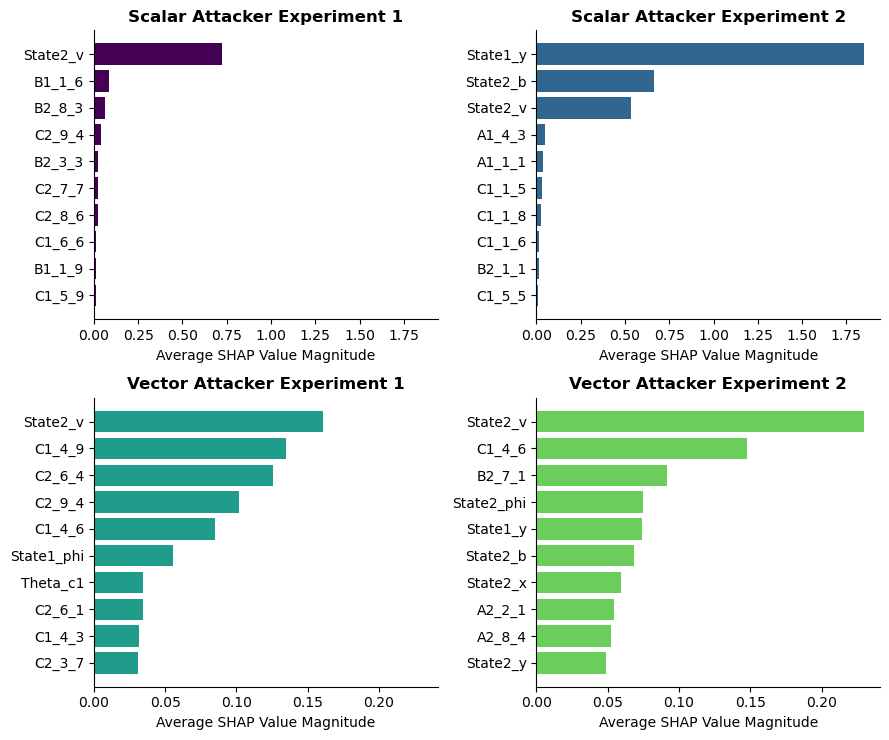

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

viridis_hex = [
    '#440154',  # Dark purple
    '#482777',  # Purple
    '#3f4a8a',  # Blue-purple
    '#31678e',  # Blue
    '#26838f',  # Teal-blue
    '#1f9d8a',  # Teal
    '#6cce5a',  # Green
    '#b6de2b',  # Yellow-green
    '#fee825',  # Yellow
    '#f0f921'   # Bright yellow
]

color_lst = [
    '#440154',  # Dark purple
    '#31678e',  # Blue
    '#1f9d8a',  # Teal
    '#6cce5a'   # Green
]

file_lst = ['../out/scalar_take1/action2/shap/baseline.feather',
            '../out/scalar_take2/action2/shap/baseline.feather',
            '../out/vector_take1/action2/shap/baseline.feather',
            '../out/vector_take2/action2/shap/baseline.feather']

# Create subplot titles
titles = ['Scalar Attacker Experiment 1', 'Scalar Attacker Experiment 2', 'Vector Attacker Experiment 1', 'Vector Attacker Experiment 2']

# Create 2x2 subplot figure
fig, axes = plt.subplots(2, 2, figsize=(9, 7.5))
axes = axes.flatten()  # Flatten to make indexing easier

top_n = 10

# First pass: find the max values for scalar and vector experiments separately
scalar_max = 0
vector_max = 0
for i, file in enumerate(file_lst):
    df = pd.read_feather(file)
    target_col = df.columns[-1]
    shap_values = df.drop(columns=[target_col])
    mean_abs_shap = shap_values.abs().mean().sort_values(ascending=True)
    top_features = mean_abs_shap.tail(top_n)
    
    if i < 2:  # Scalar experiments (indices 0, 1)
        scalar_max = max(scalar_max, top_features.max())
    else:  # Vector experiments (indices 2, 3)
        vector_max = max(vector_max, top_features.max())

# Second pass: plot with consistent scale within experiment types
for i, file in enumerate(file_lst):
    df = pd.read_feather(file)
    
    # Remove the target column (assuming it's the last column based on your data)
    target_col = df.columns[-1]  # 'P2 Vector Cost'
    shap_values = df.drop(columns=[target_col])
    
    # Calculate mean absolute SHAP values for each feature
    mean_abs_shap = shap_values.abs().mean().sort_values(ascending=True)
    top_features = mean_abs_shap.tail(top_n)
    
    # Plot on the corresponding subplot
    bars = axes[i].barh(range(len(top_features)), top_features.values,
                       color=color_lst[i])
    axes[i].set_yticks(range(len(top_features)))
    axes[i].set_yticklabels(top_features.index)
    axes[i].set_xlabel('Average SHAP Value Magnitude')
    axes[i].set_title(f'{titles[i]}', fontweight='bold',)
    
    # Remove top and right spines
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

    # Set consistent x-axis limits within experiment type
    if i < 2:  # Scalar experiments
        axes[i].set_xlim(0, scalar_max * 1.05)  # Add 5% padding
    else:  # Vector experiments
        axes[i].set_xlim(0, vector_max * 1.05)  # Add 5% padding

plt.tight_layout()
plt.show()

In [21]:
import pandas as pd
import numpy as np
from scipy.stats import entropy

def shannon_entropy_shap(shap_values):
    """
    Calculate Shannon entropy from SHAP values using normalized absolute values.
    
    Parameters:
    shap_values: array-like, SHAP values for features
    
    Returns:
    float: Shannon entropy in nats
    """
    abs_shap = np.abs(shap_values)
    if abs_shap.sum() == 0:
        return 0
    probabilities = abs_shap / abs_shap.sum()
    return entropy(probabilities)  # base=e by default, units = nats

# Example usage
file_lst = ['../out/scalar_take1/action2/shap/baseline.feather',
            '../out/scalar_take2/action2/shap/baseline.feather',
            '../out/vector_take1/action2/shap/baseline.feather',
            '../out/vector_take2/action2/shap/baseline.feather']

titles = ['Scalar Attacker Experiment 1', 'Scalar Attacker Experiment 2', 
          'Vector Attacker Experiment 1', 'Vector Attacker Experiment 2']

for i, file in enumerate(file_lst):
    df = pd.read_feather(file)
    target_col = df.columns[-1]
    shap_values = df.drop(columns=[target_col])
    
    # Calculate mean absolute SHAP values
    mean_abs_shap = shap_values.abs().mean()
    
    # Calculate Shannon entropy
    shap_entropy = shannon_entropy_shap(mean_abs_shap.values)
    
    print(f"{titles[i]}: {shap_entropy:.3f} nats")

Scalar Attacker Experiment 1: 1.233 nats
Scalar Attacker Experiment 2: 1.409 nats
Vector Attacker Experiment 1: 4.516 nats
Vector Attacker Experiment 2: 3.924 nats


Shap values, 3 metrics and methods

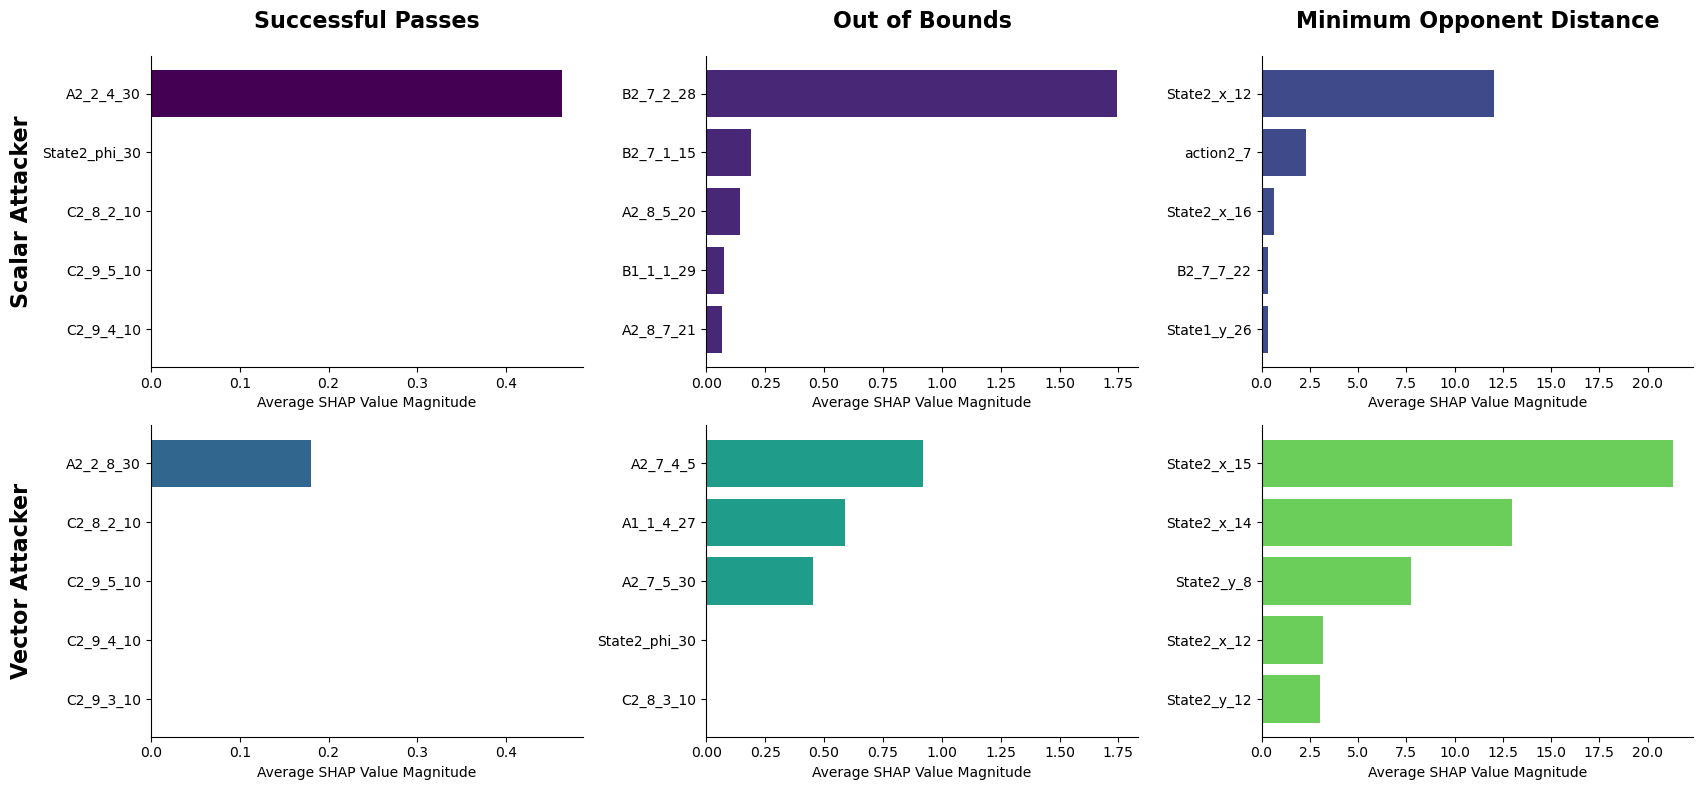

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

color_lst = [
    '#440154',  # Dark purple
    '#482777',  # Purple
    '#3f4a8a',  # Blue-purple
    '#31678e',  # Blue
    '#1f9d8a',  # Teal
    '#6cce5a',   # Green
]

file_lst = ['../out/scalar_take2/Passes P2/shap/baseline.feather',
            '../out/scalar_take2/Out of Bounds P2/shap/baseline.feather',
            '../out/scalar_take2/Min_Distance/shap/baseline.feather',
            '../out/vector_take2/Passes P2/shap/baseline.feather',
            '../out/vector_take2/Out of Bounds P2/shap/baseline.feather',
            '../out/vector_take2/Min_Distance/shap/baseline.feather']

# Column titles (for each column)
column_titles = ['Successful Passes', 'Out of Bounds', 'Minimum Opponent Distance']
# Row titles (for each row)
row_titles = ['Scalar Attacker', 'Vector Attacker']

# Create 2x3 subplot figure
fig, axes = plt.subplots(2, 3, figsize=(17, 8))

top_n = 5

# First pass: find the max values for each column separately
column_max = [0, 0, 0]  # For 3 columns
for i, file in enumerate(file_lst):
    col = i % 3   # Calculate column index
    
    df = pd.read_feather(file)
    target_col = df.columns[-1]
    shap_values = df.drop(columns=[target_col])
    mean_abs_shap = shap_values.abs().mean().sort_values(ascending=True)
    top_features = mean_abs_shap.tail(top_n)
    
    column_max[col] = max(column_max[col], top_features.max())

# Second pass: plot with consistent scale within each column
for i, file in enumerate(file_lst):
    row = i // 3  # Calculate row index
    col = i % 3   # Calculate column index
    
    df = pd.read_feather(file)
    
    # Remove the target column (assuming it's the last column based on your data)
    target_col = df.columns[-1]  # 'P2 Vector Cost'
    shap_values = df.drop(columns=[target_col])
    
    # Calculate mean absolute SHAP values for each feature
    mean_abs_shap = shap_values.abs().mean().sort_values(ascending=True)
    top_features = mean_abs_shap.tail(top_n)
    
    # Plot on the corresponding subplot
    bars = axes[row, col].barh(range(len(top_features)), top_features.values,
                               color=color_lst[i])
    axes[row, col].set_yticks(range(len(top_features)))
    axes[row, col].set_yticklabels(top_features.index)
    axes[row, col].set_xlabel('Average SHAP Value Magnitude')
    
    # Remove top and right spines
    axes[row, col].spines['top'].set_visible(False)
    axes[row, col].spines['right'].set_visible(False)
    
    # Set consistent x-axis limits within each column
    axes[row, col].set_xlim(0, column_max[col] * 1.05)  # Add 5% padding

# Add column titles
for col, title in enumerate(column_titles):
    axes[0, col].set_title(title, fontsize=16, fontweight='bold', pad=20)

# Add row titles
for row, title in enumerate(row_titles):
    axes[row, 0].text(-0.3, 0.5, title, transform=axes[row, 0].transAxes,
                      fontsize=16, fontweight='bold', rotation=90, 
                      verticalalignment='center', horizontalalignment='center')

plt.tight_layout()
plt.show()

In [36]:
for i, file in enumerate(file_lst):
    row = i // 3  # Calculate row index
    col = i % 3   # Calculate column index
    
    df = pd.read_feather(file)
    target_col = df.columns[-1]
    shap_values = df.drop(columns=[target_col])
    
    # Calculate mean absolute SHAP values
    mean_abs_shap = shap_values.abs().mean()
    
    # Calculate Shannon entropy
    shap_entropy = shannon_entropy_shap(mean_abs_shap.values)
    
    # Create title using row and column titles
    title = f"{row_titles[row]} - {column_titles[col]}"
    print(f"{title}: {shap_entropy:.3f} nats")

Scalar Attacker - Successful Passes: 0.000 nats
Scalar Attacker - Out of Bounds: 0.935 nats
Scalar Attacker - Minimum Opponent Distance: 4.796 nats
Vector Attacker - Successful Passes: 0.000 nats
Vector Attacker - Out of Bounds: 1.055 nats
Vector Attacker - Minimum Opponent Distance: 3.240 nats


Cost Matrix Heat Map

/tmp/ipykernel_316556/2622977663.py:172: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



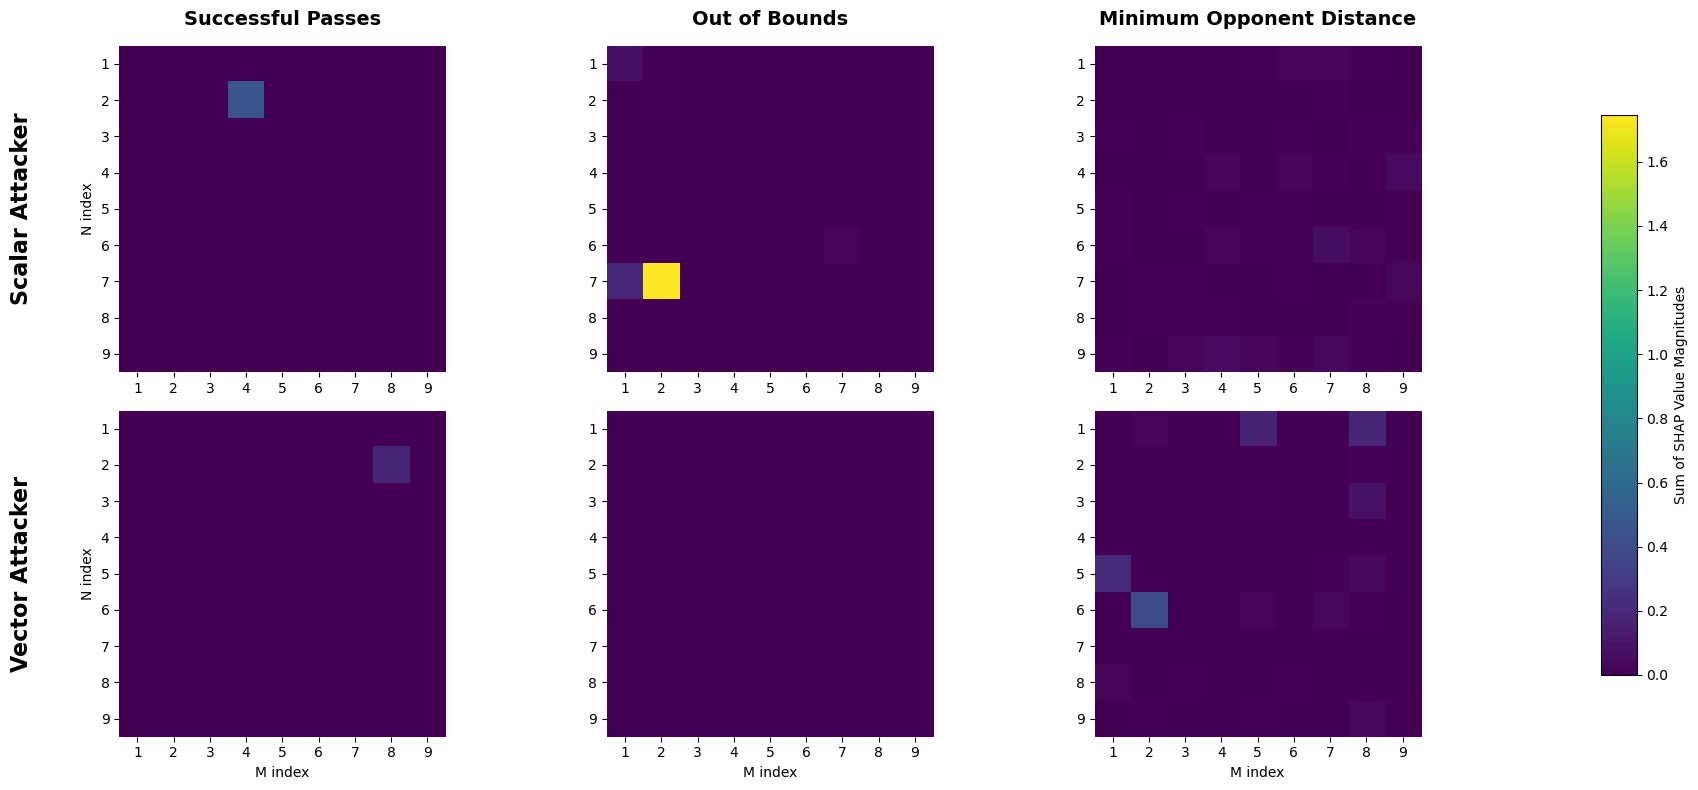

Summary of loaded data:
Scalar - Passes (A): 81 unique positions
Scalar - Out of Bounds (B): 81 unique positions
Scalar - Min_Distance (C): 81 unique positions
Vector - Passes (A): 81 unique positions
Vector - Out of Bounds (B): 81 unique positions
Vector - Min_Distance (C): 81 unique positions


In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

# File paths and configuration
file_lst = [
    '../out/scalar_take2/Passes P2/shap/baseline.feather',
    '../out/scalar_take2/Out of Bounds P2/shap/baseline.feather',
    '../out/scalar_take2/Min_Distance/shap/baseline.feather',
    '../out/vector_take2/Passes P2/shap/baseline.feather',
    '../out/vector_take2/Out of Bounds P2/shap/baseline.feather',
    '../out/vector_take2/Min_Distance/shap/baseline.feather'
]

# Column titles (for each column) - 3 columns: A, B, C
column_titles = ['Successful Passes', 'Out of Bounds', 'Minimum Opponent Distance']

# Row titles (for each row)
row_titles = ['Scalar Attacker', 'Vector Attacker']

# Mapping from problem type to group letter
problem_to_group = {
    'Passes': 'A',
    'Out of Bounds': 'B', 
    'Min_Distance': 'C'
}

def extract_indices_from_format(name):
    """Extract n, m from Ax_n_m_r format"""
    match = re.match(r'^([ABC])\w*_(\d+)_(\d+)_(\d+)', name)
    if match:
        n = int(match.group(2))  # Second group is n
        m = int(match.group(3))  # Third group is m
        return n, m
    return None, None

def build_9x9_heatmap(features, mean_abs_shap):
    """Build a 9x9 heatmap from features"""
    # Initialize 9x9 grid with NaN
    heatmap = np.full((9, 9), np.nan)
    
    # Group features by (n, m) and sum across rounds
    feature_groups = {}
    
    for feature in features:
        n, m = extract_indices_from_format(feature)
        if n is not None and m is not None and 1 <= n <= 9 and 1 <= m <= 9:
            key = (n, m)
            if key not in feature_groups:
                feature_groups[key] = []
            feature_groups[key].append(feature)
    
    # Sum SHAP values across rounds for each (n, m) position
    for (n, m), feature_list in feature_groups.items():
        # Sum the mean absolute SHAP values for all rounds at this position
        sum_shap = np.sum([mean_abs_shap[f] for f in feature_list])
        heatmap[n-1, m-1] = sum_shap  # Convert to 0-based indexing
    
    return heatmap, len(feature_groups)

def get_problem_type(filepath):
    """Extract problem type from filepath"""
    if 'Passes' in filepath:
        return 'Passes'
    elif 'Out of Bounds' in filepath:
        return 'Out of Bounds'
    elif 'Min_Distance' in filepath:
        return 'Min_Distance'
    return 'Unknown'

# Create 2x3 subplot figure
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

# Collect all heatmaps and their valid values for consistent color scaling
all_heatmaps = []
all_valid_values = []

# First pass: load all data and create heatmaps
for i, file_path in enumerate(file_lst):
    try:
        df = pd.read_feather(file_path)
        
        # Remove target column
        target_col = df.columns[-1]
        shap_values = df.drop(columns=[target_col])
        
        # Compute mean |SHAP| values
        mean_abs_shap = shap_values.abs().mean()
        
        # Get problem type and corresponding group
        problem_type = get_problem_type(file_path)
        group_letter = problem_to_group.get(problem_type, 'A')
        
        # Extract features for this group
        group_features = []
        for col in shap_values.columns:
            match = re.match(rf'^{group_letter}\w*_(\d+)_(\d+)_(\d+)', col)
            if match:
                group_features.append(col)
        
        # Build heatmap
        heatmap, num_positions = build_9x9_heatmap(group_features, mean_abs_shap)
        all_heatmaps.append((heatmap, num_positions, problem_type, group_letter))
        
        # Collect valid values for color scaling
        valid_values = heatmap[~np.isnan(heatmap)]
        if len(valid_values) > 0:
            all_valid_values.extend(valid_values)
            
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        all_heatmaps.append((np.full((9, 9), np.nan), 0, 'Error', 'X'))

# Set consistent color scale
if all_valid_values:
    vmin, vmax = np.min(all_valid_values), np.max(all_valid_values)
else:
    vmin, vmax = 0, 1

# Second pass: plot all heatmaps
im = None
for i, (heatmap, num_positions, problem_type, group_letter) in enumerate(all_heatmaps):
    row = i // 3  # 0 for scalar (first 3 files), 1 for vector (last 3 files)
    col = i % 3   # 0, 1, 2 for A, B, C respectively
    
    if num_positions == 0:
        axes[row, col].set_title(f"{problem_type} ({group_letter}) - No Data")
        axes[row, col].axis("off")
        continue
    
    # Create heatmap
    im = axes[row, col].imshow(heatmap, cmap="viridis", origin="upper", vmin=vmin, vmax=vmax)
    
    # Set ticks for 9x9 grid
    axes[row, col].set_xticks(np.arange(9))
    axes[row, col].set_yticks(np.arange(9))
    axes[row, col].set_xticklabels(np.arange(1, 10))
    axes[row, col].set_yticklabels(np.arange(1, 10))
    
    # Add subtle grid
    # axes[row, col].set_xticks(np.arange(-0.5, 9), minor=True)
    # axes[row, col].set_yticks(np.arange(-0.5, 9), minor=True)
    # axes[row, col].grid(which="minor", color="white", linestyle='-', linewidth=0.3, alpha=0.3)
    
    # Set title only for top row
    if row == 0:
        axes[row, col].set_title(column_titles[col], fontsize=14, fontweight='bold', pad=15)
    
    # Add axis labels
    if row == 1:  # Bottom row
        axes[row, col].set_xlabel("M index", fontsize=10)
    if col == 0:  # First column
        axes[row, col].set_ylabel("N index", fontsize=10)
    
    # Remove spines for cleaner look
    for spine in axes[row, col].spines.values():
        spine.set_visible(False)

# Add row titles
for row, title in enumerate(row_titles):
    axes[row, 0].text(-0.3, 0.5, title, transform=axes[row, 0].transAxes,
                     fontsize=16, fontweight='bold', rotation=90,
                     verticalalignment='center', horizontalalignment='center')

# Add colorbar
if im is not None:
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax, label="Sum of SHAP Value Magnitudes")
    cbar.ax.tick_params(labelsize=10)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

# Print summary
print("Summary of loaded data:")
for i, (heatmap, num_positions, problem_type, group_letter) in enumerate(all_heatmaps):
    row_type = "Scalar" if i < 3 else "Vector"
    print(f"{row_type} - {problem_type} ({group_letter}): {num_positions} unique positions")

In [63]:
import pandas as pd
import numpy as np
import re
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# File paths and configuration
file_lst = [
    '../out/scalar_take2/Passes P2/shap/baseline.feather',
    '../out/scalar_take2/Out of Bounds P2/shap/baseline.feather',
    '../out/scalar_take2/Min_Distance/shap/baseline.feather',
    '../out/vector_take2/Passes P2/shap/baseline.feather',
    '../out/vector_take2/Out of Bounds P2/shap/baseline.feather',
    '../out/vector_take2/Min_Distance/shap/baseline.feather'
]

# Column titles and row titles
column_titles = ['Passes (A)', 'Bounds (B)', 'Distance (C)']
row_titles = ['Scalar Attacker', 'Vector Attacker']

# Mapping from problem type to group letter
problem_to_group = {
    'Passes': 'A',
    'Out of Bounds': 'B', 
    'Min_Distance': 'C'
}

def extract_indices_from_format(name):
    """Extract n, m from Ax_n_m_r format"""
    match = re.match(r'^([ABC])\w*_(\d+)_(\d+)_(\d+)', name)
    if match:
        n = int(match.group(2))  # Second group is n
        m = int(match.group(3))  # Third group is m
        return n, m
    return None, None

def build_9x9_heatmap(features, mean_abs_shap):
    """Build a 9x9 heatmap from features"""
    # Initialize 9x9 grid with zeros
    heatmap = np.zeros((9, 9))
    hover_text = np.empty((9, 9), dtype=object)
    
    # Group features by (n, m) and sum across rounds
    feature_groups = {}
    
    for feature in features:
        n, m = extract_indices_from_format(feature)
        if n is not None and m is not None and 1 <= n <= 9 and 1 <= m <= 9:
            key = (n, m)
            if key not in feature_groups:
                feature_groups[key] = []
            feature_groups[key].append(feature)
    
    # Sum SHAP values across rounds for each (n, m) position
    for i in range(9):
        for j in range(9):
            n, m = i + 1, j + 1  # Convert to 1-based indexing
            key = (n, m)
            
            if key in feature_groups:
                feature_list = feature_groups[key]
                sum_shap = np.sum([mean_abs_shap[f] for f in feature_list])
                heatmap[i, j] = sum_shap
                
                # Create hover text with feature details
                hover_info = f"Position ({n}, {m})<br>"
                hover_info += f"Total Importance: {sum_shap:.4f}<br>"
                hover_info += f"Features ({len(feature_list)}):<br>"
                
                # Sort by importance and show top features
                sorted_features = sorted([(f, mean_abs_shap[f]) for f in feature_list], 
                                       key=lambda x: x[1], reverse=True)
                
                for k, (feature, imp) in enumerate(sorted_features[:5]):  # Top 5
                    hover_info += f"  {feature}: {imp:.4f}<br>"
                
                if len(feature_list) > 5:
                    hover_info += f"  ... and {len(feature_list) - 5} more"
                
                hover_text[i, j] = hover_info
            else:
                hover_text[i, j] = f"Position ({n}, {m})<br>No data"
    
    return heatmap, hover_text

def get_problem_type(filepath):
    """Extract problem type from filepath"""
    if 'Passes' in filepath:
        return 'Passes'
    elif 'Out of Bounds' in filepath:
        return 'Out of Bounds'
    elif 'Min_Distance' in filepath:
        return 'Min_Distance'
    return 'Unknown'

# Load and process all data
all_heatmaps = []
all_hover_texts = []
all_valid_values = []

for i, file_path in enumerate(file_lst):
    try:
        df = pd.read_feather(file_path)
        
        # Remove target column
        target_col = df.columns[-1]
        shap_values = df.drop(columns=[target_col])
        
        # Compute mean |SHAP| values
        mean_abs_shap = shap_values.abs().mean()
        
        # Get problem type and corresponding group
        problem_type = get_problem_type(file_path)
        group_letter = problem_to_group.get(problem_type, 'A')
        
        # Extract features for this group
        group_features = []
        for col in shap_values.columns:
            match = re.match(rf'^{group_letter}\w*_(\d+)_(\d+)_(\d+)', col)
            if match:
                group_features.append(col)
        
        # Build heatmap
        heatmap, hover_text = build_9x9_heatmap(group_features, mean_abs_shap)
        all_heatmaps.append((heatmap, problem_type, group_letter))
        all_hover_texts.append(hover_text)
        
        # Collect valid values for color scaling
        nonzero_values = heatmap[heatmap > 0]
        if len(nonzero_values) > 0:
            all_valid_values.extend(nonzero_values)
            
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        all_heatmaps.append((np.zeros((9, 9)), 'Error', 'X'))
        all_hover_texts.append(np.full((9, 9), f"Error loading {file_path}", dtype=object))

# Set consistent color scale
if all_valid_values:
    vmax = np.max(all_valid_values)
else:
    vmax = 1

# Create subplot figure
fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=[f"{title}" for title in column_titles],
    vertical_spacing=0.15,
    horizontal_spacing=0.1
)

# Add heatmaps to subplots
for i, ((heatmap, problem_type, group_letter), hover_text) in enumerate(zip(all_heatmaps, all_hover_texts)):
    row = i // 3 + 1  # Plotly uses 1-based indexing
    col = i % 3 + 1
    
    fig.add_trace(
        go.Heatmap(
            z=heatmap,
            hovertemplate='%{customdata}<extra></extra>',
            customdata=hover_text,
            colorscale='Viridis',
            zmin=0,
            zmax=vmax,
            showscale=(i == 0),  # Only show colorbar for first subplot
            colorbar=dict(
                title="Total |SHAP| Value",
                # titleside="right",
                x=1.02,
                len=0.8
            ) if i == 0 else None
        ),
        row=row, col=col
    )
    
    # Update axes for this subplot
    fig.update_xaxes(
        title_text="M index" if row == 2 else None,
        tickmode='linear',
        tick0=0,
        dtick=1,
        tickvals=list(range(9)),
        ticktext=[str(i+1) for i in range(9)],
        row=row, col=col
    )
    
    fig.update_yaxes(
        title_text="N index" if col == 1 else None,
        tickmode='linear',
        tick0=0,
        dtick=1,
        tickvals=list(range(9)),
        ticktext=[str(i+1) for i in range(9)],
        row=row, col=col
    )

# Add row annotations
for i, row_title in enumerate(row_titles):
    fig.add_annotation(
        x=-0.15, y=0.75 - i * 0.5,
        text=row_title,
        textangle=90,
        xref="paper", yref="paper",
        showarrow=False,
        font=dict(size=16, color="black"),
        xanchor="center", yanchor="middle"
    )

# Update layout
fig.update_layout(
    title={
        'text': "Interactive SHAP Heatmaps - Hover for Details",
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 20}
    },
    height=800,
    width=1200,
    margin=dict(l=100, r=100, t=100, b=50)
)

fig.show()

# Print summary
print("Summary of loaded data:")
for i, (heatmap, problem_type, group_letter) in enumerate(all_heatmaps):
    row_type = "Scalar" if i < 3 else "Vector"
    num_positions = np.sum(heatmap > 0)
    print(f"{row_type} - {problem_type} ({group_letter}): {num_positions} positions with data")

print("\nInteractive features:")
print("- Hover over any cell to see detailed feature information")
print("- Zoom and pan using plotly controls")
print("- Click and drag to select regions")

Summary of loaded data:
Scalar - Passes (A): 1 positions with data
Scalar - Out of Bounds (B): 6 positions with data
Scalar - Min_Distance (C): 81 positions with data
Vector - Passes (A): 1 positions with data
Vector - Out of Bounds (B): 0 positions with data
Vector - Min_Distance (C): 51 positions with data

Interactive features:
- Hover over any cell to see detailed feature information
- Zoom and pan using plotly controls
- Click and drag to select regions


/tmp/ipykernel_316556/1735262335.py:188: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



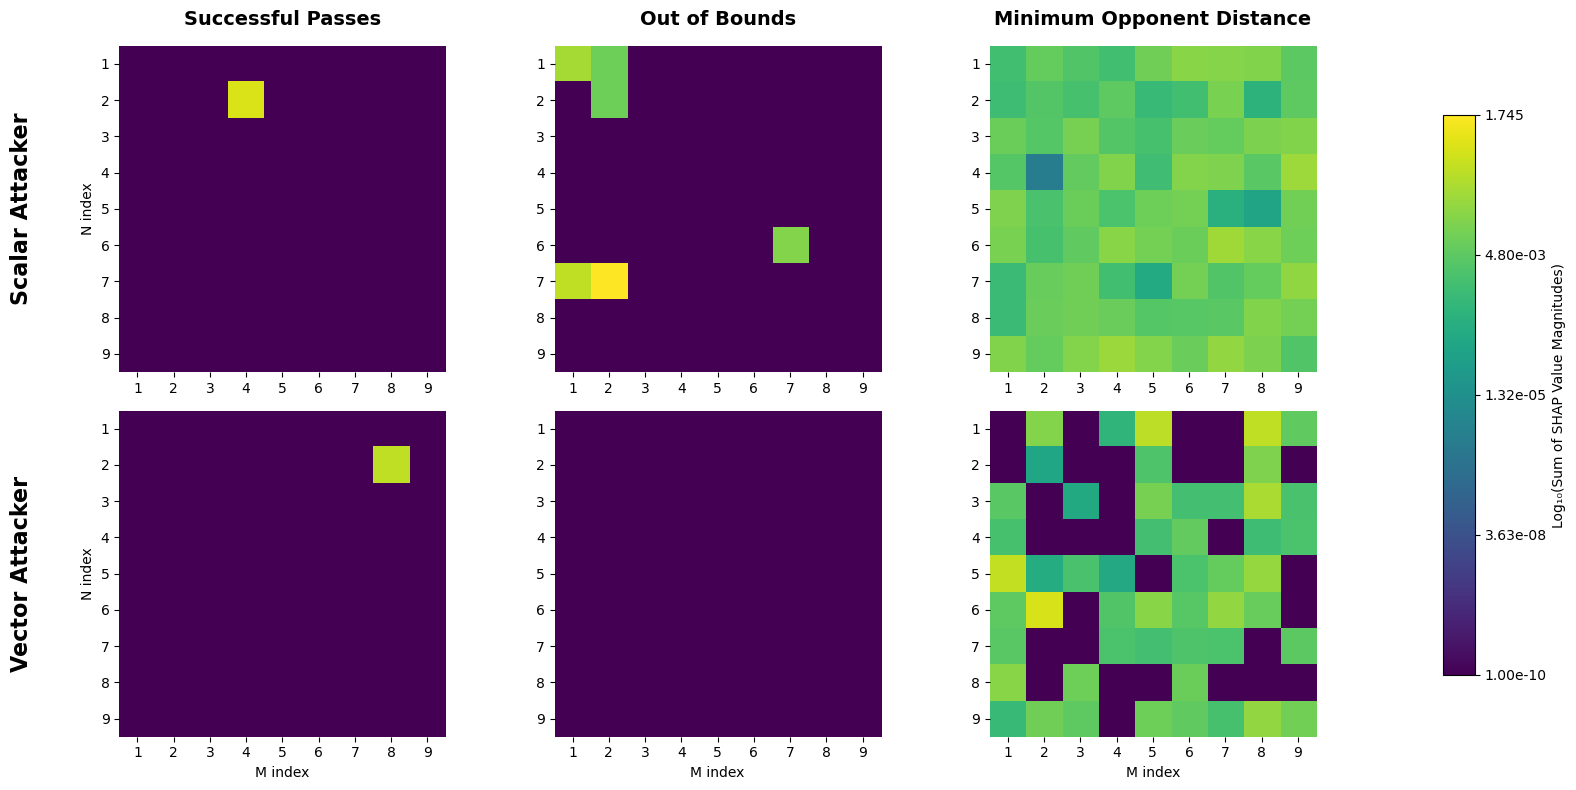

Summary of loaded data:
Scalar - Passes (A): 81 unique positions
Scalar - Out of Bounds (B): 81 unique positions
Scalar - Min_Distance (C): 81 unique positions
Vector - Passes (A): 81 unique positions
Vector - Out of Bounds (B): 81 unique positions
Vector - Min_Distance (C): 81 unique positions


In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

# File paths and configuration
file_lst = [
    '../out/scalar_take2/Passes P2/shap/baseline.feather',
    '../out/scalar_take2/Out of Bounds P2/shap/baseline.feather',
    '../out/scalar_take2/Min_Distance/shap/baseline.feather',
    '../out/vector_take2/Passes P2/shap/baseline.feather',
    '../out/vector_take2/Out of Bounds P2/shap/baseline.feather',
    '../out/vector_take2/Min_Distance/shap/baseline.feather'
]

# Column titles (for each column) - 3 columns: A, B, C
column_titles = ['Successful Passes', 'Out of Bounds', 'Minimum Opponent Distance']

# Row titles (for each row)
row_titles = ['Scalar Attacker', 'Vector Attacker']

# Mapping from problem type to group letter
problem_to_group = {
    'Passes': 'A',
    'Out of Bounds': 'B', 
    'Min_Distance': 'C'
}

def extract_indices_from_format(name):
    """Extract n, m from Ax_n_m_r format"""
    match = re.match(r'^([ABC])\w*_(\d+)_(\d+)_(\d+)', name)
    if match:
        n = int(match.group(2))  # Second group is n
        m = int(match.group(3))  # Third group is m
        return n, m
    return None, None

def build_9x9_heatmap(features, mean_abs_shap):
    """Build a 9x9 heatmap from features"""
    # Initialize 9x9 grid with NaN
    heatmap = np.full((9, 9), np.nan)
    
    # Group features by (n, m) and sum across rounds
    feature_groups = {}
    
    for feature in features:
        n, m = extract_indices_from_format(feature)
        if n is not None and m is not None and 1 <= n <= 9 and 1 <= m <= 9:
            key = (n, m)
            if key not in feature_groups:
                feature_groups[key] = []
            feature_groups[key].append(feature)
    
    # Sum SHAP values across rounds for each (n, m) position
    for (n, m), feature_list in feature_groups.items():
        # Sum the mean absolute SHAP values for all rounds at this position
        sum_shap = np.sum([mean_abs_shap[f] for f in feature_list])
        heatmap[n-1, m-1] = sum_shap  # Convert to 0-based indexing
    
    return heatmap, len(feature_groups)

def get_problem_type(filepath):
    """Extract problem type from filepath"""
    if 'Passes' in filepath:
        return 'Passes'
    elif 'Out of Bounds' in filepath:
        return 'Out of Bounds'
    elif 'Min_Distance' in filepath:
        return 'Min_Distance'
    return 'Unknown'

# Create 2x3 subplot figure
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

# Collect all heatmaps and their valid values for consistent color scaling
all_heatmaps = []
all_valid_values = []

# First pass: load all data and create heatmaps
for i, file_path in enumerate(file_lst):
    try:
        df = pd.read_feather(file_path)
        
        # Remove target column
        target_col = df.columns[-1]
        shap_values = df.drop(columns=[target_col])
        
        # Compute mean |SHAP| values
        mean_abs_shap = shap_values.abs().mean()
        
        # Get problem type and corresponding group
        problem_type = get_problem_type(file_path)
        group_letter = problem_to_group.get(problem_type, 'A')
        
        # Extract features for this group
        group_features = []
        for col in shap_values.columns:
            match = re.match(rf'^{group_letter}\w*_(\d+)_(\d+)_(\d+)', col)
            if match:
                group_features.append(col)
        
        # Build heatmap
        heatmap, num_positions = build_9x9_heatmap(group_features, mean_abs_shap)
        all_heatmaps.append((heatmap, num_positions, problem_type, group_letter))
        
        # Collect valid values for color scaling
        valid_values = heatmap[~np.isnan(heatmap)]
        if len(valid_values) > 0:
            all_valid_values.extend(valid_values)
            
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        all_heatmaps.append((np.full((9, 9), np.nan), 0, 'Error', 'X'))

# Set consistent color scale with log scaling
if all_valid_values:
    # Use log scale, but handle zeros by adding small epsilon
    epsilon = 1e-10
    all_valid_values = np.array(all_valid_values)
    log_values = np.log10(all_valid_values + epsilon)
    vmin, vmax = np.min(log_values), np.max(log_values)
else:
    vmin, vmax = -10, 0  # Default log scale range

# Second pass: plot all heatmaps
im = None
for i, (heatmap, num_positions, problem_type, group_letter) in enumerate(all_heatmaps):
    row = i // 3  # 0 for scalar (first 3 files), 1 for vector (last 3 files)
    col = i % 3   # 0, 1, 2 for A, B, C respectively
    
    if num_positions == 0:
        axes[row, col].set_title(f"{problem_type} ({group_letter}) - No Data")
        axes[row, col].axis("off")
        continue
    
    # Apply log transformation to heatmap data
    log_heatmap = np.full_like(heatmap, np.nan)
    mask = ~np.isnan(heatmap)
    if np.any(mask):
        # Add small epsilon to avoid log(0)
        epsilon = 1e-10
        log_heatmap[mask] = np.log10(heatmap[mask] + epsilon)
    
    # Create heatmap with log-scaled data
    im = axes[row, col].imshow(log_heatmap, cmap="viridis", origin="upper", vmin=vmin, vmax=vmax)
    
    # Set ticks for 9x9 grid
    axes[row, col].set_xticks(np.arange(9))
    axes[row, col].set_yticks(np.arange(9))
    axes[row, col].set_xticklabels(np.arange(1, 10))
    axes[row, col].set_yticklabels(np.arange(1, 10))
    
    # Set title only for top row
    if row == 0:
        axes[row, col].set_title(column_titles[col], fontsize=14, fontweight='bold', pad=15)
    
    # Add axis labels
    if row == 1:  # Bottom row
        axes[row, col].set_xlabel("M index", fontsize=10)
    if col == 0:  # First column
        axes[row, col].set_ylabel("N index", fontsize=10)
    
    # Remove spines for cleaner look
    for spine in axes[row, col].spines.values():
        spine.set_visible(False)

# Add row titles
for row, title in enumerate(row_titles):
    axes[row, 0].text(-0.3, 0.5, title, transform=axes[row, 0].transAxes,
                     fontsize=16, fontweight='bold', rotation=90,
                     verticalalignment='center', horizontalalignment='center')

# Add colorbar
if im is not None:
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax, label="Log₁₀(Sum of SHAP Value Magnitudes)")
    cbar.ax.tick_params(labelsize=10)
    
    # Add custom tick labels to show actual values
    if len(all_valid_values) > 0:
        # Create meaningful tick positions
        tick_positions = np.linspace(vmin, vmax, 5)
        actual_values = 10**tick_positions
        tick_labels = [f"{val:.2e}" if val < 0.01 else f"{val:.3f}" for val in actual_values]
        cbar.set_ticks(tick_positions)
        cbar.set_ticklabels(tick_labels)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

# Print summary
print("Summary of loaded data:")
for i, (heatmap, num_positions, problem_type, group_letter) in enumerate(all_heatmaps):
    row_type = "Scalar" if i < 3 else "Vector"
    print(f"{row_type} - {problem_type} ({group_letter}): {num_positions} unique positions")

/tmp/ipykernel_316556/1764382969.py:150: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



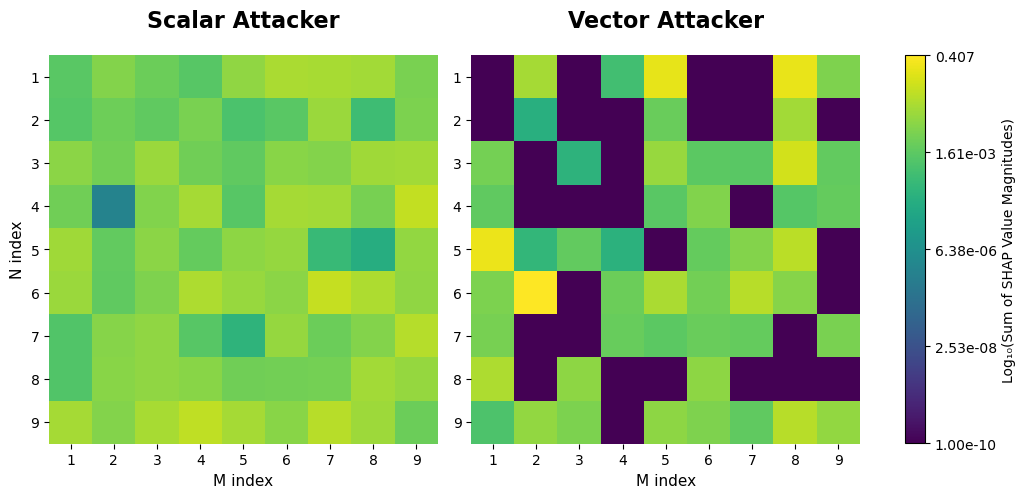

Summary of loaded data:
Scalar Attacker - Minimum Opponent Distance: 81 unique positions
Vector Attacker - Minimum Opponent Distance: 81 unique positions


In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

# File paths for Min_Distance only
file_lst = [
    '../out/scalar_take2/Min_Distance/shap/baseline.feather',
    '../out/vector_take2/Min_Distance/shap/baseline.feather'
]

# Row titles (for each row)
row_titles = ['Scalar Attacker', 'Vector Attacker']

def extract_indices_from_format(name):
    """Extract n, m from Ax_n_m_r format"""
    match = re.match(r'^([ABC])\w*_(\d+)_(\d+)_(\d+)', name)
    if match:
        n = int(match.group(2))  # Second group is n
        m = int(match.group(3))  # Third group is m
        return n, m
    return None, None

def build_9x9_heatmap(features, mean_abs_shap):
    """Build a 9x9 heatmap from features"""
    # Initialize 9x9 grid with NaN
    heatmap = np.full((9, 9), np.nan)
    
    # Group features by (n, m) and sum across rounds
    feature_groups = {}
    
    for feature in features:
        n, m = extract_indices_from_format(feature)
        if n is not None and m is not None and 1 <= n <= 9 and 1 <= m <= 9:
            key = (n, m)
            if key not in feature_groups:
                feature_groups[key] = []
            feature_groups[key].append(feature)
    
    # Sum SHAP values across rounds for each (n, m) position
    for (n, m), feature_list in feature_groups.items():
        # Sum the mean absolute SHAP values for all rounds at this position
        sum_shap = np.sum([mean_abs_shap[f] for f in feature_list])
        heatmap[n-1, m-1] = sum_shap  # Convert to 0-based indexing
    
    return heatmap, len(feature_groups)

# Create 2x1 subplot figure
fig, axes = plt.subplots(1, 2, figsize=(10, 8))

# Collect all heatmaps and their valid values for consistent color scaling
all_heatmaps = []
all_valid_values = []

# First pass: load all data and create heatmaps
for i, file_path in enumerate(file_lst):
    try:
        df = pd.read_feather(file_path)
        
        # Remove target column
        target_col = df.columns[-1]
        shap_values = df.drop(columns=[target_col])
        
        # Compute mean |SHAP| values
        mean_abs_shap = shap_values.abs().mean()
        
        # Extract C (Min_Distance) features only
        group_features = []
        for col in shap_values.columns:
            match = re.match(r'^C\w*_(\d+)_(\d+)_(\d+)', col)
            if match:
                group_features.append(col)
        
        # Build heatmap
        heatmap, num_positions = build_9x9_heatmap(group_features, mean_abs_shap)
        all_heatmaps.append((heatmap, num_positions))
        
        # Collect valid values for color scaling
        valid_values = heatmap[~np.isnan(heatmap)]
        if len(valid_values) > 0:
            all_valid_values.extend(valid_values)
            
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        all_heatmaps.append((np.full((9, 9), np.nan), 0))

# Set consistent color scale with log scaling
if all_valid_values:
    # Use log scale, but handle zeros by adding small epsilon
    epsilon = 1e-10
    all_valid_values = np.array(all_valid_values)
    log_values = np.log10(all_valid_values + epsilon)
    vmin, vmax = np.min(log_values), np.max(log_values)
else:
    vmin, vmax = -10, 0  # Default log scale range

# Second pass: plot all heatmaps
im = None
for i, (heatmap, num_positions) in enumerate(all_heatmaps):
    if num_positions == 0:
        axes[i].set_title(f"{row_titles[i]} - No Data")
        axes[i].axis("off")
        continue
    
    # Apply log transformation to heatmap data
    log_heatmap = np.full_like(heatmap, np.nan)
    mask = ~np.isnan(heatmap)
    if np.any(mask):
        # Add small epsilon to avoid log(0)
        epsilon = 1e-10
        log_heatmap[mask] = np.log10(heatmap[mask] + epsilon)
    
    # Create heatmap with log-scaled data
    im = axes[i].imshow(log_heatmap, cmap="viridis", origin="upper", vmin=vmin, vmax=vmax)
    
    # Set ticks for 9x9 grid
    axes[i].set_xticks(np.arange(9))
    axes[i].set_yticks(np.arange(9))
    axes[i].set_xticklabels(np.arange(1, 10))
    axes[i].set_yticklabels(np.arange(1, 10))
    
    # Set title
    axes[i].set_title(f"{row_titles[i]}", 
                     fontsize=16, fontweight='bold', pad=20)
    
    # Add axis labels
    axes[i].set_xlabel("M index", fontsize=11)
    if i == 0:  # Only add Y-label to the first (left) subplot
        axes[i].set_ylabel("N index", fontsize=11)
    
    # Remove spines for cleaner look
    for spine in axes[i].spines.values():
        spine.set_visible(False)

# Add colorbar
if im is not None:
    cbar_ax = fig.add_axes([0.91, 0.2575, 0.02, 0.485])
    cbar = fig.colorbar(im, cax=cbar_ax, label="Log₁₀(Sum of SHAP Value Magnitudes)")
    cbar.ax.tick_params(labelsize=10)
    
    # Add custom tick labels to show actual values
    if len(all_valid_values) > 0:
        # Create meaningful tick positions
        tick_positions = np.linspace(vmin, vmax, 5)
        actual_values = 10**tick_positions
        tick_labels = [f"{val:.2e}" if val < 0.01 else f"{val:.3f}" for val in actual_values]
        cbar.set_ticks(tick_positions)
        cbar.set_ticklabels(tick_labels)

plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()

# Print summary
print("Summary of loaded data:")
for i, (heatmap, num_positions) in enumerate(all_heatmaps):
    print(f"{row_titles[i]} - Minimum Opponent Distance: {num_positions} unique positions")

## Sembas


Critical moments superimposed

Grid/Sembas Comparison